In [190]:
import seaborn as sns
import networkx as nx
from scipy.signal import argrelextrema
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import types


sns.set()
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 4.0})

plt.style.use(
    'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [157]:
def readEdges(filename):
    edges=np.loadtxt(filename)
    edges.sort()
    edges.sort(axis=0)
    return edges

def readTrigs(filename):
    trigs=np.loadtxt(filename)
    trigs.sort()
    trigs.sort(axis=0)
    return trigs

def B1fromEdges(n, edges):
    B1=np.zeros((n, edges.shape[0]))

    for i in range(edges.shape[0]):
        B1[int(edges[i, 0]),i]=-1
        B1[int(edges[i, 1]),i]=1
    return B1

def B2fromTrig(n, edges, trigs):
    B2=np.zeros((len(edges), trigs.shape[0]))

    for i in range(trigs.shape[0]):
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 1]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 2]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 1], trigs[i, 2]])).all(axis=1))[0][0] ,i]=-1
    return B2

def getRandomWeights(edges):
    return np.random.uniform(size=(edges.shape[0]))

def getAdjB1(B1):
    return np.diag(np.diag(B1.dot(B1.T)))-B1.dot(B1.T)

def inv(A, thr=1e-10):
    w=np.diag(A)
    ans=np.zeros(w.shape[0])
    #ans[np.abs(w)<thr]=0
    #ans[np.abs(w)>=thr]=np.divide(1, w[np.abs(w)>=thr])
    ans=1./w
    return np.diag(ans)

def getPosFromB1(B1):
    A=getAdjB1(B1)
    G = nx.from_numpy_matrix(np.array(A))  
    pos = nx.spring_layout(G)
    return np.array(list(pos.values()))

def simpleDrawB1(B1, w, points, eps=0, e=0):
    
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)
    for i in range(points.shape[0]):
        plt.annotate(str(i), (points[i,0], points[i,1]))
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], linewidth=8*((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])
    
def getL1k(L1, thr=1e-8):
    return np.sum(np.abs(np.linalg.eig(L1)[0])<thr)

def getFk_l2(L1, k, thr=1e-8):
    #k=getL1k(L1, thr=thr)
    vals, vecs=np.linalg.eig(L1)
    idx = vals.argsort() 
    vals = vals[idx]
    
    return np.sqrt(np.sum(np.power(vals[:k+1], 2)))

def Sym(A):
    return 0.5*(A+A.T)

def scal(A, B):
    return np.trace(A.T.dot(B))

In [195]:
def getDt(B2, W):
    w_t = np.diag(W).reshape(-1, 1)
    ones = np.ones(B2.shape[1]).reshape(-1, 1)
    tmp = np.multiply(ones.dot(w_t.T), np.abs(B2).T)
    minval=np.zeros(tmp.shape[0])
    for i in range(tmp.shape[0]):
        if (tmp[i, np.nonzero(tmp[i])]).shape[1]==3:
            minval[i]=np.min(tmp[i, np.nonzero(tmp[i])])
    return np.diag(minval)


def HodgeLW_fr(B1, B2, w, e=0, eps=0):
    W = np.diag(np.sqrt(w)+eps*e)
    Dt = getDt(B2, W)
    L1 = W.dot(B1.T.dot(B1.dot(W))) + \
        inv(W).dot(B2.dot(Dt.dot(Dt.dot(B2.T)).dot(inv(W))))
    #if np.sum((L1-L1.T)>1e-8)>0:
   #     print("SHIT!!!")
    return Sym(L1)

In [196]:
def getG_i(i, B1, B2, L1_E, vecs, w, e, eps):
    W = np.diag(np.sqrt(w)+eps*e)
    x = vecs[:, i].reshape(-1, 1)
    Dt = getDt(B2, W)
    P2 = inv(W).dot(B2.dot(Dt.dot(Dt.dot(B2.T.dot(inv(W))))))
    w_t = np.diag(W).reshape(-1, 1)
    ones = np.ones(B2.shape[1]).reshape(-1, 1)
    tmp = np.multiply(ones.dot(w_t.T), np.abs(B2).T)
    M = np.zeros(B2.T.shape)
    tmp[tmp == 0] = 2*np.max(w_t)
    ind = np.argmax(-tmp, axis=1)
    M[np.arange(0, M.shape[0], 1), ind] = 1
    Add = np.diag(
        M.T.dot(np.diag(B2.T.dot(inv(W).dot(x.dot(x.T.dot(inv(W).dot(B2.dot(Dt)))))))))
    Gi = 2.*Sym(B1.T.dot(B1.dot(W.dot(x.dot(x.T)))) -
                inv(W).dot(x.dot(x.T.dot(P2))))+2.*Add
    return x.T.dot(L1_E.dot(x))*Gi


def getDotE(B1, B2, w, e, eps, k, thr=1e-8):
    mask = (np.abs(w+eps*e) < thr)
    matmask = np.diag(np.logical_not((np.abs(w+eps*e) < 1e-8)))
    E = np.diag(e)
    PE = np.multiply(E, matmask)

    L1_E = HodgeLW_fr(B1, B2, w, e, eps)
    vals, vecs = np.linalg.eig(L1_E)
    idx = vals.argsort()
    vals = vals[idx]
    vecs = vecs[:, idx]
    # k=np.sum(np.abs(vals)<thr)

    GE = np.zeros(L1_E.shape)
    for i in range(k+1):
        if np.iscomplex(vals[i]):
            print(vals[i])
        GE += getG_i(i, B1, B2, L1_E, vecs, w, e, eps)

    kappa = scal(-GE, PE)/scal(PE, PE)
    PGE = np.multiply(GE, matmask)
    dE = -PGE-kappa*PE
    return dE

In [185]:
n=7
edges=readEdges('6.edges')
trigs=readTrigs('6.trigs')
B1=B1fromEdges(n, edges)
B2=B2fromTrig(n, edges, trigs)

points=getPosFromB1(B1)

In [186]:
w=getRandomWeights(edges)+0.5
#w=np.array([1.01, 1.02, 0.98, 0.97, 1.05, 0.99, 1, 0.25, 1.005, 1.1])
np.sqrt(w)

array([1.142, 1.070, 0.979, 1.066, 1.200, 1.010, 1.196, 1.138, 1.012,
       1.127])

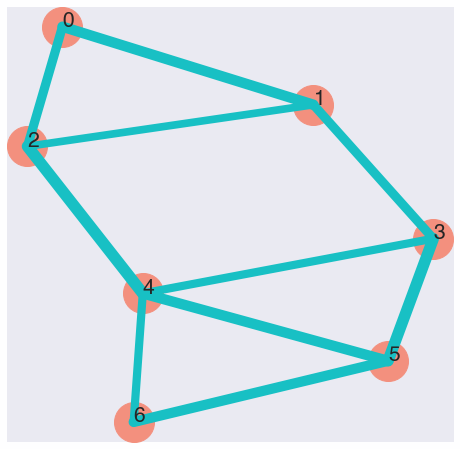

In [187]:
simpleDrawB1(B1, w, points, e=0, eps=0)

In [188]:
e = np.ones(w.shape[0])/np.sqrt(w.shape[0])
eps = 0.774
L1_E = HodgeLW_fr(B1, B2, w, e, eps)
W=np.diag( np.sqrt(w)+eps*e )
getFk_l2(L1_E, 1)

0.26493504603301943

In [167]:
eps = 0.001
#e = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
e = np.diag(getDotE(B1, B2, w, e, eps, 1))

#e = np.random.uniform(-1, 0, w.shape[0])

#e = np.array([0,0,0,0,0,0,0.1,-1.,0,0])
e = -e/np.linalg.norm(e)
eps = 0.774

p = 0.001
L1_E = HodgeLW_fr(B1, B2, w, e, eps)
track = [getFk_l2(L1_E, 1)]
h = 1e-5
t_cur = 0
log = []
ts = [0]
# fl=0

print('time: ', t_cur, ' ||  ', track[-1])

for i in range(100):
    # h=1e-3
    e0 = e

    while True:
        while True:
            print('h:  ', h, ' |  time: ', t_cur, ' ||   E_norm:', round(scal(E1, E1), 3),
                  ',    dE-orth:', round(scal(dE, E1), 3), track[-1])
            e = e0
            dE = getDotE(B1, B2, w, e, eps, 1)
            E1 = np.diag(e)+h*dE
            e = np.diag(E1)
            if np.sum(np.sqrt(w)+eps*e < 0) > 0:
                h = h/2
                # print('ups')
            else:
                break
            if h<1e-10:
                h=1e-5
                break
        L1_E = HodgeLW_fr(B1, B2, w, e, eps)
        # if not(fl):
        #    pass
        # else:
        #    fl=0
        #    break
        if getFk_l2(L1_E, 1) > track[-1]:
            h = h/2
        else:
            h = h*2
            break
    L1_E = HodgeLW_fr(B1, B2, w, e, eps)
    log.append(np.sort(np.linalg.eig(L1_E)[0]))
    track.append(getFk_l2(L1_E, 1))
    dE = getDotE(B1, B2, w, e, eps, 1)

    # if i % 10000 == 0:
    #    print('time: ', t_cur, ' ||   E_norm:', scal(E1, E1),
    #          ',    dE-orth:', scal(dE, E1), track[-1])
    t_cur += h
    ts.append(t_cur)

    # if np.std(track[-50:])/track[-1]<0.01:
    # print('!')
    #    h=1e-3
    #    fl=1

time:  0  ||   0.11023058866751033
h:   1e-05  |  time:  0  ||   E_norm: 1.043 ,    dE-orth: 0.0 0.11023058866751033
h:   2e-05  |  time:  2e-05  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.11023020397335698
h:   4e-05  |  time:  6.000000000000001e-05  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.11022943459130584
h:   8e-05  |  time:  0.00014000000000000001  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.11022789585222356
h:   0.00016  |  time:  0.00030000000000000003  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.1102248184741371
h:   0.00032  |  time:  0.0006200000000000001  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.11021866411825161
h:   0.00064  |  time:  0.0012600000000000003  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.11020635700743538
h:   0.00128  |  time:  0.0025400000000000006  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.11018174918805267
h:   0.00256  |  time:  0.0051  ||   E_norm: 1.0 ,    dE-orth: -0.0 0.11013255914575558
h:   0.00512  |  time:  0.01022  ||   E_norm: 1.0 ,    dE-orth: 0.0 0.1100342813468554
h:   0.01024  |

h:   2684.35456  |  time:  114085.06878000002  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.0003903280818187542
h:   5368.70912  |  time:  119453.77790000002  ||   E_norm: 1.043 ,    dE-orth: 0.0 0.00038252577575269823
h:   2684.35456  |  time:  119453.77790000002  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.00038252577575269823
h:   5368.70912  |  time:  124822.48702000002  ||   E_norm: 1.043 ,    dE-orth: -0.0 0.00037525092425553657
h:   2684.35456  |  time:  124822.48702000002  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.00037525092425553657
h:   5368.70912  |  time:  130191.19614000001  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.0003674929711970117
h:   2684.35456  |  time:  130191.19614000001  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.0003674929711970117
h:   5368.70912  |  time:  135559.90526000003  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.00035954206327050523
h:   2684.35456  |  time:  135559.90526000003  ||   E_norm: 1.044 ,    dE-orth: 0.0 0.00035954206327050523
h:   5368.70912  |  time:  140928.61438

[1.202 0.769 0.755 0.798 1.001 1.358 0.247 0.763 1.180 1.104]
[-0.000 0.000 0.625 1.013 1.055 2.446 2.607 4.009 5.366 6.958]


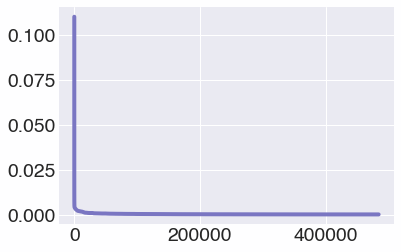

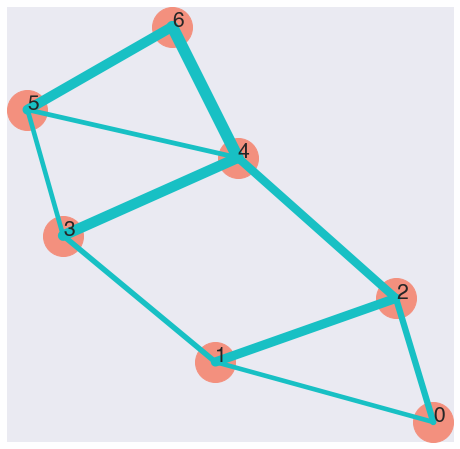

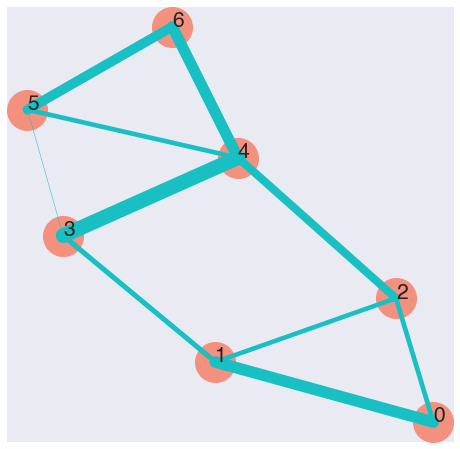

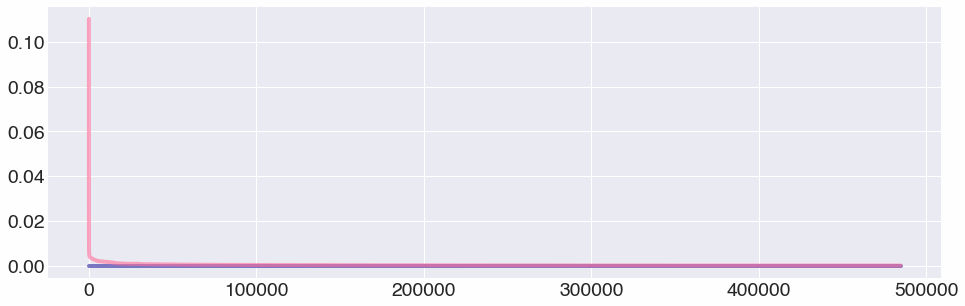

In [168]:
print(np.sqrt(w)+eps*e)
print(np.sort(np.linalg.eig(L1_E)[0]))
plt.figure()
plt.plot(ts[:], track)

simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

log=np.array(log)

plt.figure(figsize=(16, 5))
plt.plot(ts[1:], log[:, :2])

In [169]:
np.sqrt(w)

array([0.759, 0.890, 1.074, 0.828, 1.023, 1.152, 0.764, 0.774, 1.209,
       1.113])

1.9229433590143278e-16
6.675826522786778e-17
(1.886723777603365e-17-2.828415954189957e-17j)


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

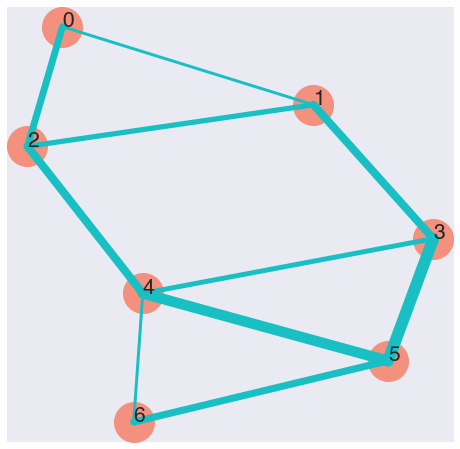

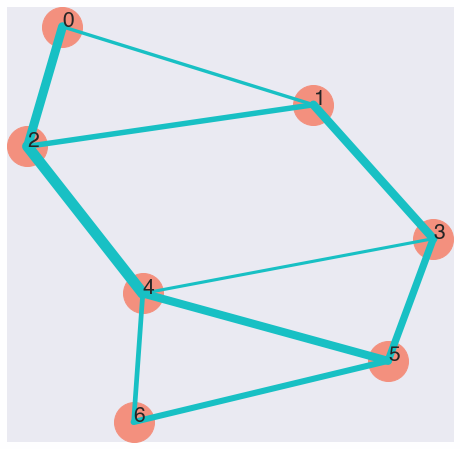

In [197]:
#eps = 0.0
#e = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
#e = np.diag(getDotE(B1, B2, w, e, eps, 1))


tmp_tracks=[]
tss=[]
#plt.figure(figsize=(16,6))
for rep in range(10):
    e = np.random.uniform(-1, 0, w.shape[0])
    e = e/np.linalg.norm(e)
    eps = 0.774

    p = 0.001
    L1_E = HodgeLW_fr(B1, B2, w, e, eps)
    track = [getFk_l2(L1_E, 1)]
    h = 1e-5
    t_cur = 0
    log = []
    ts = [0]

    #print('time: ', t_cur, ' ||  ', track[-1])

    for i in range(100):
        e0 = e
        while True:
            while True:
                #print('h:  ', h, ' |  time: ', t_cur, ' ||   E_norm:', round(scal(E1, E1), 3),
                #      ',    dE-orth:', round(scal(dE, E1), 3), track[-1])
                e = e0
                dE = getDotE(B1, B2, w, e, eps, 1)
                E1 = np.diag(e)+h*dE
                e = np.diag(E1)
                if np.sum(np.sqrt(w)+eps*e < 0) > 0:
                    h = h/2
                else:
                    break
                if h<1e-10:
                    h=1e-5
                    break
            L1_E = HodgeLW_fr(B1, B2, w, e, eps)
            if getFk_l2(L1_E, 1) > track[-1]:
                h = h/2
            else:
                h = h*2
                break
        L1_E = HodgeLW_fr(B1, B2, w, e, eps)
        log.append(np.sort(np.linalg.eig(L1_E)[0]))
        track.append(getFk_l2(L1_E, 1))
        dE = getDotE(B1, B2, w, e, eps, 1)
        t_cur += h
        ts.append(t_cur)
    #plt.semilogy(ts[:], track)
    tmp_tracks.append(track)
    tss.append(ts)
    print(track[-1])
    simpleDrawB1(B1, w, points, e, eps)

In [207]:
L1_E-L1_E.T
#np.linalg.eig(L1_E)[0]

array([[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000]])

In [ ]:
plt.figure(figsize=(16,6))
for rep in range(10):

 